## Travelling Salesman problem

In [49]:
%matplotlib widget
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

In [50]:
!pip install ortools

Lets start step by step.
Your first task is the following.
Choose five cities and store them as strings in a list `cities`. Also define a dictionary `distances` with distances between the cities. The distances do not have to be realistic. 

## Generate the Dataset

In [17]:
!pip install dwave-ocean-sdk

In [18]:
!pip install dimod dwave-system

In [66]:
from IPython.display import display, HTML

import random
import numpy as np
import itertools
import time
from ortools.linear_solver import pywraplp

random.seed(42)
cities = [
    "Munich", "Hamburg", "Stuttgart", "Berlin", "Frankfurt", 
    "Paris", "Madrid", "Barcelona", "Tenerife", "Malaga", 
    "Valencia", "Sevilla", "Lisboa", "Roma", 
    "London", "Brussels", "Amsterdam", "Zurich", "Vienna", 
    "Prague", "Warsaw", "Budapest", "Athens", "Dublin", 
    "Copenhagen", "Oslo", "Stockholm", "Helsinki", "Reykjavik", 
    "Milan", "Venice", "Naples", "Florence", "Turin", 
    "Nice", "Lyon", "Marseille", "Bordeaux", "Toulouse", 
    "Granada", "Bilbao", "Santander", "Alicante", "Zaragoza", 
    "Bruges", "Ghent", "Antwerp", "Rotterdam", "The Hague", 
    "Geneva", "Basel", "Lucerne", "Salzburg", "Innsbruck", 
    "Krakow", "Gdansk", "Wroclaw", "Poznan", "Lodz", 
    "Sofia", "Bucharest", "Belgrade", "Ljubljana", "Zagreb", 
    "Sarajevo", "Skopje", "Podgorica", "Tirana", "Vilnius", 
    "Riga", "Tallinn", "Minsk", "Saint Petersburg", "Moscow", 
    "Kyiv", "Odessa", "Chisinau", "Nicosia", "Valletta", 
    "Luxembourg", "Monaco", "San Marino", "Andorra la Vella", "Vaduz", 
    "Edinburgh", "Glasgow", "Cardiff", "Belfast", "Porto", 
    "Bratislava", "Kosice", "Split", "Dubrovnik", "Sibiu"
]

n = len(cities)
A = 10
B = 10
C = 1
distances = {}
for cindex1 in range(len(cities)-1):
    c1 = cities[cindex1]
    for cindex2 in range(cindex1+1,len(cities)):
        c2 = cities[cindex2]
        distances[c1,c2] = random.randint(1,6)
        distances[c2,c1] = distances[c1,c2]

#distances2 = {}
#distances2 = np.zeros((n, n), dtype=int)
#for i in range(n):
 #   for j in range(i + 1, n):
#        distances2[i, j] = distances2[j, i] = random.randint(1, 6)

#print("Distance Matrix:")
#print(distances2)

print(distances)

distance_matrix = np.zeros((n, n), dtype=int)
for (c1, c2), dist in distances.items():
    i, j = cities.index(c1), cities.index(c2)
    distance_matrix[i, j] = distance_matrix[j, i] = dist

print("Distance Matrix:")
print(distance_matrix)


{('Munich', 'Hamburg'): 6, ('Hamburg', 'Munich'): 6, ('Munich', 'Stuttgart'): 1, ('Stuttgart', 'Munich'): 1, ('Munich', 'Berlin'): 1, ('Berlin', 'Munich'): 1, ('Munich', 'Frankfurt'): 6, ('Frankfurt', 'Munich'): 6, ('Munich', 'Paris'): 3, ('Paris', 'Munich'): 3, ('Munich', 'Madrid'): 2, ('Madrid', 'Munich'): 2, ('Munich', 'Barcelona'): 2, ('Barcelona', 'Munich'): 2, ('Munich', 'Tenerife'): 2, ('Tenerife', 'Munich'): 2, ('Munich', 'Malaga'): 6, ('Malaga', 'Munich'): 6, ('Munich', 'Valencia'): 1, ('Valencia', 'Munich'): 1, ('Munich', 'Sevilla'): 6, ('Sevilla', 'Munich'): 6, ('Munich', 'Lisboa'): 6, ('Lisboa', 'Munich'): 6, ('Munich', 'Roma'): 5, ('Roma', 'Munich'): 5, ('Munich', 'London'): 1, ('London', 'Munich'): 1, ('Munich', 'Brussels'): 5, ('Brussels', 'Munich'): 5, ('Munich', 'Amsterdam'): 4, ('Amsterdam', 'Munich'): 4, ('Munich', 'Zurich'): 1, ('Zurich', 'Munich'): 1, ('Munich', 'Vienna'): 1, ('Vienna', 'Munich'): 1, ('Munich', 'Prague'): 1, ('Prague', 'Munich'): 1, ('Munich', 'War

In [67]:
import dimod


solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise Exception("Solver no disponible.")
x = {}
for i in range(n):
    for j in range(n):
        if i != j:
            x[i, j] = solver.BoolVar(f'x[{i},{j}]')

# Variables para el sub-tour elimination
u = {}
for i in range(1, n):
    u[i] = solver.IntVar(0, n-1, f'u[{i}]')

# Restricciones
# Cada ciudad debe ser visitada exactamente una vez
for i in range(n):
    solver.Add(solver.Sum([x[i, j] for j in range(n) if i != j]) == 1)
    solver.Add(solver.Sum([x[j, i] for j in range(n) if i != j]) == 1)

# Sub-tour elimination constraints
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            solver.Add(u[i] - u[j] + n * x[i, j] <= n - 1)

### Resultados

In [ ]:

import time
import psutil
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # Convertir a MB


# Función objetivo
solver.Minimize(solver.Sum([distance_matrix[i, j] * x[i, j] for i in range(n) for j in range(n) if i != j]))

initial_memory = get_memory_usage()

start_time = time.time()

# Resolver el problema
status = solver.Solve()
end_time = time.time()
final_memory = get_memory_usage()

# Obtener la solución
if status == pywraplp.Solver.OPTIMAL:
    route = []
    for i in range(n):
        for j in range(n):
            if i != j and x[i, j].solution_value() > 0.5:
                route.append((i, j))
    sorted_route = [0]
    while len(sorted_route) < n:
        for (i, j) in route:
            if i == sorted_route[-1]:
                sorted_route.append(j)
                break
    sorted_route.append(sorted_route[0])
    total_distance = sum(distance_matrix[sorted_route[i], sorted_route[i + 1]] for i in range(n))

    print("La ruta óptima es:", [cities[i] for i in sorted_route])
    print("Distancia total recorrida:", total_distance)
else:
    print("No se encontró solución óptima.")

print("Tiempo de ejecución:", end_time - start_time, "segundos")
print("Uso de memoria inicial:", initial_memory, "MB")
print("Uso de memoria final:", final_memory, "MB")
print("Incremento de uso de memoria:", final_memory - initial_memory, "MB")

pressed CTRL-C 1 times (5 times for forcing termination)


### Draw Solution

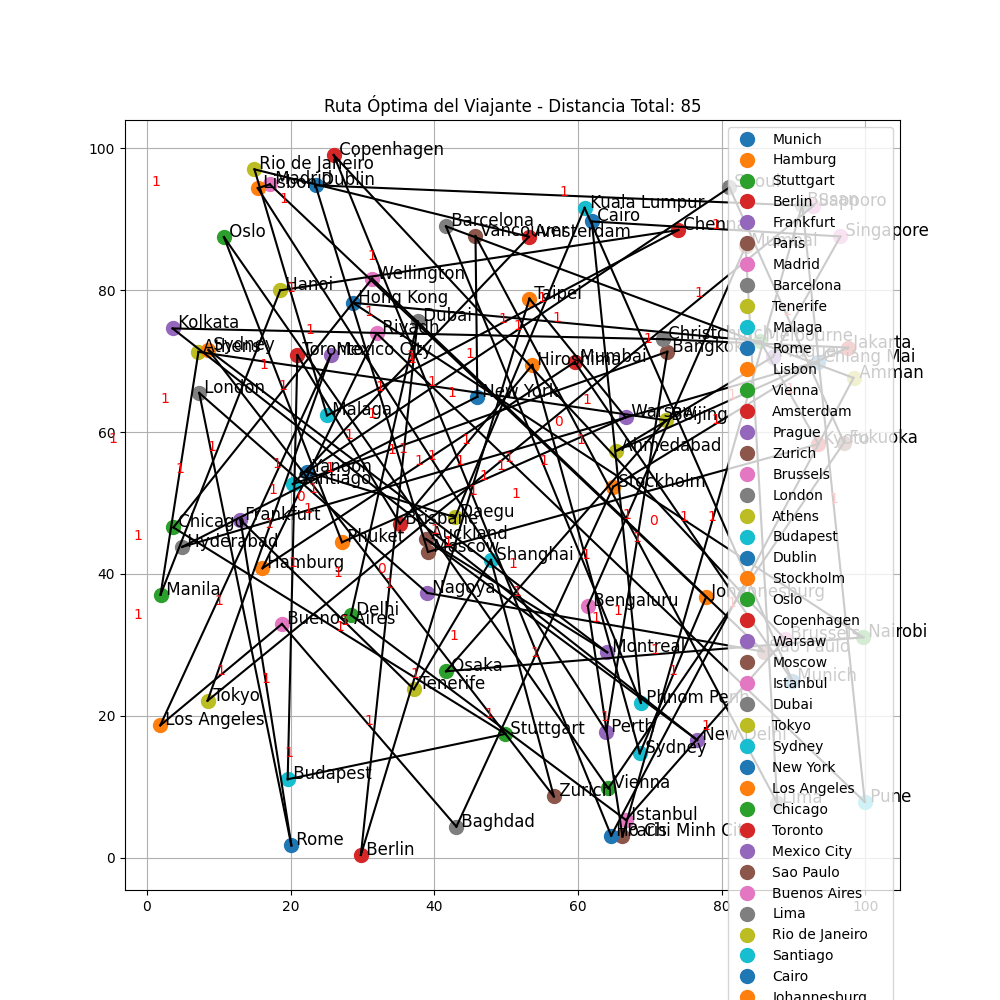

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Función para visualizar la ruta y las distancias entre ciudades
def plot_route(route, cities, distance_matrix):
    n = len(cities)
    plt.figure(figsize=(10, 10))  # Aumentar el tamaño del gráfico
    ax = plt.gca()

    # Coordenadas de las ciudades (para visualización)
    coords = np.random.rand(n, 2) * 100  # Coordenadas aleatorias en un plano 100x100
    for i, (x, y) in enumerate(coords):
        ax.plot(x, y, 'o', markersize=10, label=cities[i])
        ax.text(x, y, f' {cities[i]}', fontsize=12)

    # Dibujar la ruta y añadir las distancias
    total_distance = 0
    for i in range(n):
        start_city = route[i]
        end_city = route[(i + 1) % n]
        start_coord = coords[start_city]
        end_coord = coords[end_city]
        ax.plot([start_coord[0], end_coord[0]], [start_coord[1], end_coord[1]], 'k-')
        
        # Calcular el punto medio para poner la etiqueta de la distancia
        mid_point = (start_coord + end_coord) / 2
        distance = distance_matrix[start_city, end_city]
        total_distance += distance
        
        # Ajustar posición de la etiqueta para que no se solape
        label_offset = np.array([0, 0])  # Ajuste vertical
        if start_coord[0] > end_coord[0]:
            label_offset[0] = -15  # Ajuste horizontal si necesario
        ax.text(mid_point[0] + label_offset[0], mid_point[1] + label_offset[1], 
                f'{distance}', color='red', fontsize=10, ha='center')

    # Dibujar la línea de regreso a la ciudad inicial
    start_city = route[0]
    start_coord = coords[start_city]
    end_coord = coords[route[-1]]
    ax.plot([start_coord[0], end_coord[0]], [start_coord[1], end_coord[1]], 'k-')

    plt.title(f"Ruta Óptima del Viajante - Distancia Total: {total_distance}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para dibujar la ruta con distancias
plot_route(sorted_route, cities, distance_matrix)
